# Run Basener's script, investigate his Gamma gimmick

**Requires that Node.js and gzip be installed on the host machine**

Here we run (the relevant part of) Basener's JavaScript, `BS.js`, and generate the data for the numerical experiments of BS Sections 5.2, 5.3, and 5.4. The data will be stored in files named `bs5_2.json.gz`, `bs5_3.json.gz`, and `bs5_4.json.gz`. We'll be interested also in some data relevant to Section 5.2, though BS did not report upon it. These data will be stored in the file `bs5_2aux.json.gz`.

The results that Basener and Sanford report in Section 5.4 are crucially dependent on an unreported gimmick in Basener's code. Our first use of the data will be to investigate the gimmick.

In [1]:
%matplotlib notebook
%run bs.py

plt.rcParams['animation.html'] = 'jshtml' # 'html5' requires FFmpeg on server
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette(sns.color_palette("Set2", 4))

## Section 5.2: No mutations

First generate a command line `c` to run the script, and then submit it to the command line interpreter (shell) of the host computer.

In [2]:
n_years = 3500
case = 'NoneExact'
c = bs_command(percentage_of_mutations_that_are_beneficial=None,
               mutation_distribution_type=case,
               population_size='Infinite',
               number_of_years=n_years,
               number_of_discrete_population_fitness_values=N_RATES[case],
               script_path='BS.js',
               output_path='bs5_2.json')
!{c}

Working...
... output is in bs5_2.json


In [3]:
case = 'None'
c = bs_command(percentage_of_mutations_that_are_beneficial=None,
               mutation_distribution_type=case,
               population_size='Infinite',
               number_of_years=n_years,
               number_of_discrete_population_fitness_values=N_RATES[case],
               script_path='BS.js',
               output_path='bs5_2aux.json')
!{c}

Working...
... output is in bs5_2aux.json


## Section 5.3: Gaussian

The standard deviation in Basener's code was not set to 0.002 as in the BS article, so I have changed it in `BS.js`.

In [4]:
case = 'Gaussian'
c = bs_command(percentage_of_mutations_that_are_beneficial=None,
               mutation_distribution_type=case,
               population_size='Finite',
               number_of_years=300,
               number_of_discrete_population_fitness_values=N_RATES[case],
               script_path='BS.js',
               output_path='bs5_3.json')
!{c}

Working...
... output is in bs5_3.json


## Section 5.4: Gamma

Later cells in the notebook use the data from this computation.

In [5]:
case = 'Gamma'
c = bs_command(percentage_of_mutations_that_are_beneficial=0.001,
               mutation_distribution_type=case,
               population_size='Finite',
               number_of_years=2500,
               number_of_discrete_population_fitness_values=N_RATES[case],
               script_path='BS.js',
               output_path='bs5_4.json')
!{c}

Working...
... output is in bs5_4.json


## Compress the files

The files are very large.

In [6]:
!ls -l bs5_*.json

-rw-r--r--. 1 chronos chronos 23512580 Apr 19 16:04 bs5_2aux.json
-rw-r--r--. 1 chronos chronos 23539058 Apr 19 16:03 bs5_2.json
-rw-r--r--. 1 chronos chronos   888218 Apr 19 16:04 bs5_3.json
-rw-r--r--. 1 chronos chronos 14473190 Apr 19 16:05 bs5_4.json


So we compress them (forcing gzip to overwrite the compressed files if they already exist).

In [7]:
!gzip -9 --force bs5_*.json

Now the files are merely large.

In [8]:
!ls -l bs5_*.json.gz

-rw-r--r--. 1 chronos chronos 9834054 Apr 19 16:04 bs5_2aux.json.gz
-rw-r--r--. 1 chronos chronos 9739724 Apr 19 16:03 bs5_2.json.gz
-rw-r--r--. 1 chronos chronos  384299 Apr 19 16:04 bs5_3.json.gz
-rw-r--r--. 1 chronos chronos 5741549 Apr 19 16:05 bs5_4.json.gz


## Example use: Investigation of Basener's Gamma gimmick

I've extended Basener's code to output the values of some variables at the end of execution. The following loads the association of variables and values for BS Section 5.4 into a Python dictionary.

In [9]:
bs_data5_4 = bs_data('bs5_4')

Here are the names that I have given the variables.

In [10]:
bs_data5_4.keys()

dict_keys(['percent_beneficial', 'mutation_type', 'population_size', 'n_years', 'n_rates', 'birth_rates', 'trajectory', 'growth_rates', 'means', 'variances', 'mutation_probs', 'bin_width'])

All but one of the entries in the dictionary are dumps of Basener's data. The `mutation_probs` array is generated by code that I added at the end of Basener's script. It stores the results of calling the `mutationProbs()` function with each of the possible effects of mutation on growth rate. Basener generates a similar array when plotting (code not included in `BS.js`). However, he slices the interval of mutation effects much more finely when plotting than when doing the calculations, and thereby makes it impossible to detect his gimmicky and erroneous handling of the Gamma distribution.

Let's take a look of our own at Basener's distribution of probability over the possible effects of mutation on the growth rate (fitness) of the offspring.

<IPython.core.display.Javascript object>


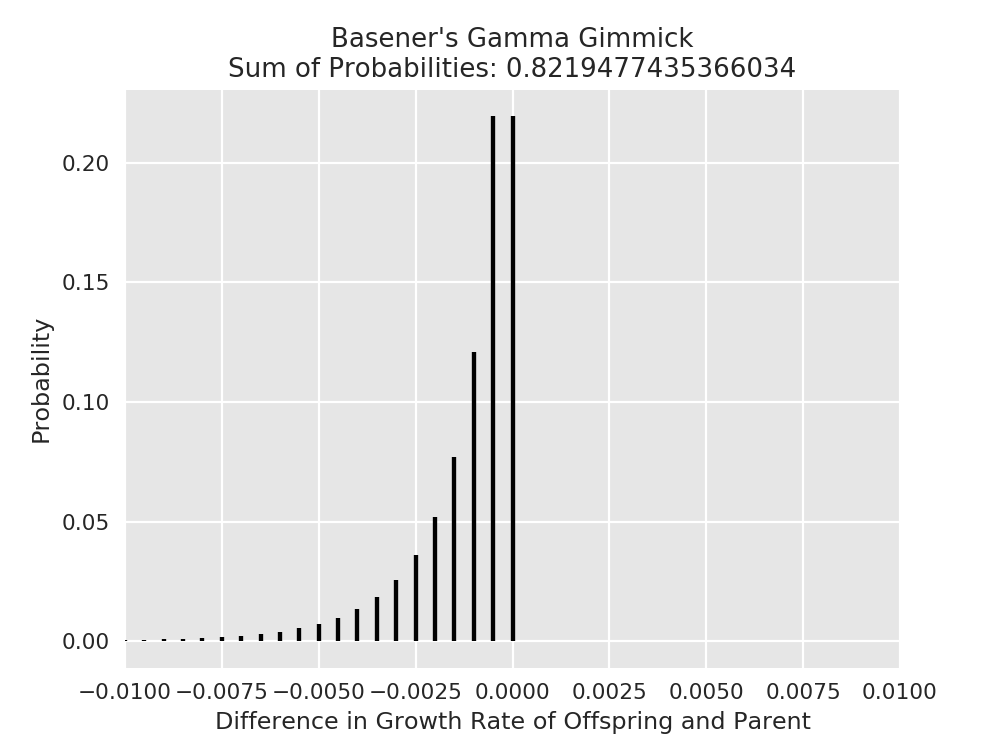

In [11]:
mutation_probs = np.array(bs_data5_4['mutation_probs'])
birth_rates = np.array(bs_data5_4['birth_rates'])
mutation_effects = np.concatenate((-birth_rates[::-1], birth_rates[1:]))
plt.vlines(mutation_effects, 0, mutation_probs)
title = "Basener's Gamma Gimmick\nSum of Probabilities: {0}"
plt.title(title.format(np.sum(mutation_probs)))
plt.ylabel('Probability')
plt.xlabel('Difference in Growth Rate of Offspring and Parent')
plt.xlim(-0.01, 0.01);

What Basener has done is to set the probability that mutation has zero effect on the growth rate of the offspring to the probability that mutation has a minimally deleterious effect. This greatly reduces the probability of zero effect. Although the results of Section 5.4 are crucially dependent on Basener's gimmick, BS did not report upon it. Comparing the figure above to their [Figure 1](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs00285-017-1190-x/MediaObjects/285_2017_1190_Fig1_HTML.gif), it is easy to see that they did not plot the distribution that they actually used in their calculations.

The significance of the probabilities summing to .82, as indicated in the subtitle of the plot, is that Basener's code silently reduces the number of offspring by 18 percent when calculating the effects of mutation on their growth rates. That is, the actual birth rate is the product of the stated birth rate and the $L^1$ norm of the mutation effects distribution.

Basener has also botched the reweighting of the distribution, which is supposed to make the probability of positive effect equal to .001. Summing the probabilities of mutation effects greater than zero, we find that Basener has set them about 40 percent smaller than claimed.

In [12]:
np.sum(mutation_probs[mutation_effects > 0])

0.0006024717944449918

We can wrap the growth rates and the trajectory in an instance of a subclass of `Evolution`, and then treat them much as we treat the results of Python computations. The following figure agrees with [Figure 10](https://media.springernature.com/original/springer-static/image/art%3A10.1007%2Fs00285-017-1190-x/MediaObjects/285_2017_1190_Fig10_HTML.gif) of the BS article.

<IPython.core.display.Javascript object>


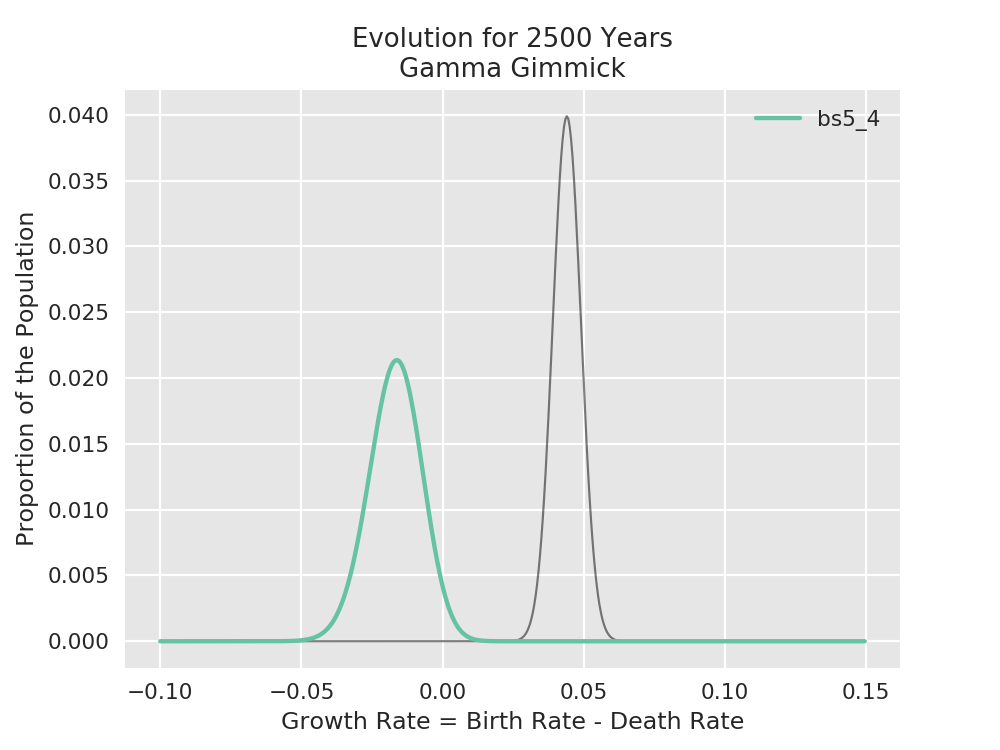

In [13]:
bs5_4 = WrappedTrajectory(bs_data5_4['trajectory'], bs_data5_4['growth_rates'], label='bs5_4')
c = CompareProcesses([bs5_4], subtitle='\nGamma Gimmick')
c.animate(None)

 The figures below agree with the other figures in [Section 5.4](https://link.springer.com/article/10.1007/s00285-017-1190-x#Sec13) of the BS article.

<IPython.core.display.Javascript object>


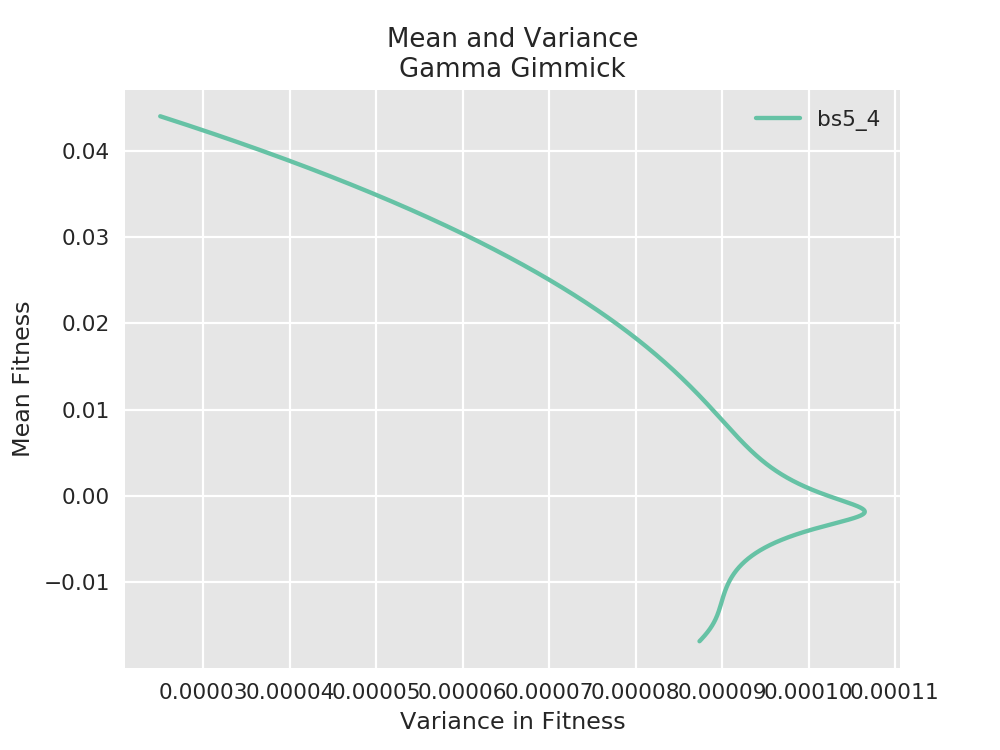

<IPython.core.display.Javascript object>


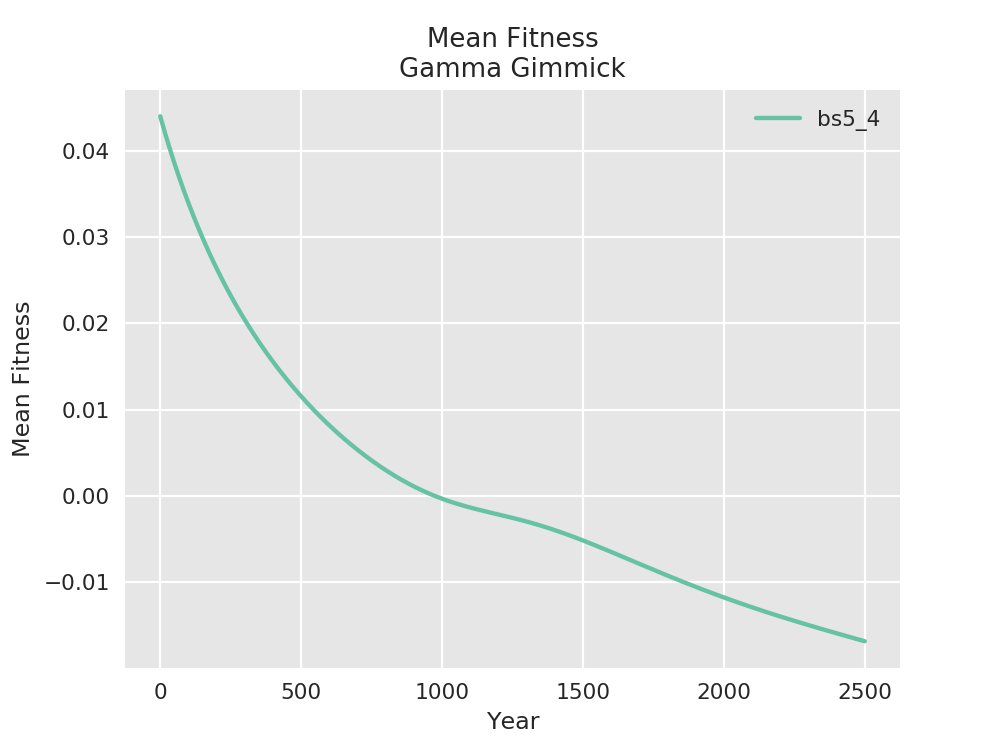

<IPython.core.display.Javascript object>


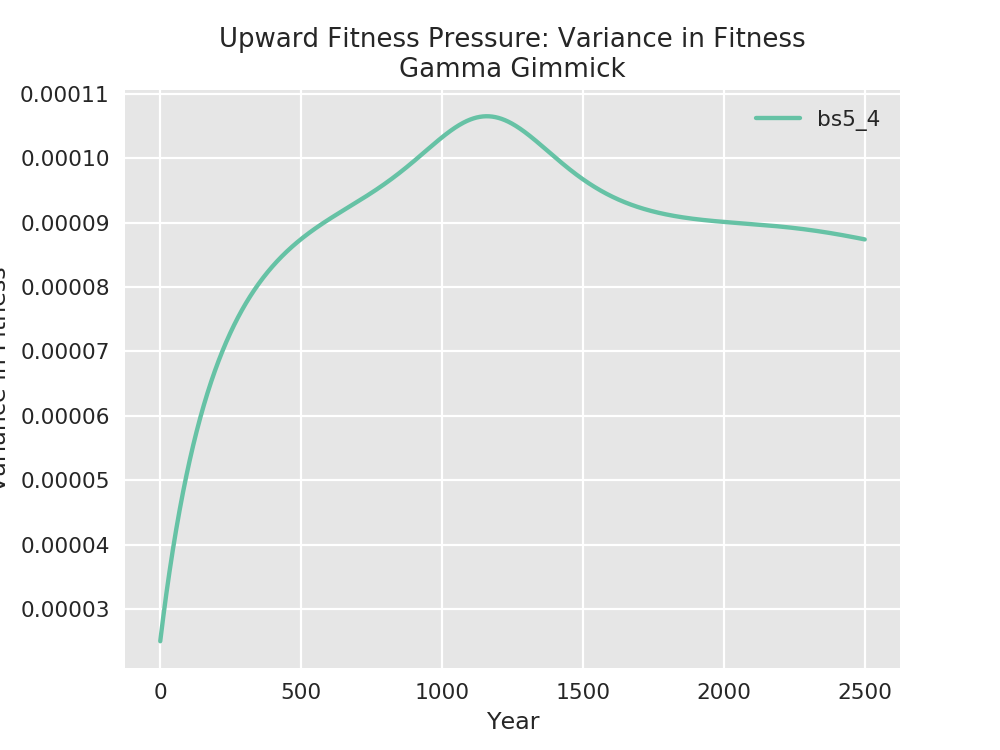

In [14]:
c.mean_variance_plots()

### Basener's code for the Gamma case

You need only inspect the first two lines of the code to see the gimmick. Note that `mDiff` is the difference in Malthusian growth rate of the offspring from the parent, and that `mDelta` is the minimum difference of two growth rates.

```javascript
if (mDiff == 0)      // If the difference in Malthusian growth rate is 0...
    mDiff = -mDelta; // then set it to the least negative difference.
var sBarBeneficial = 0.001;
var sBarDeleterious = 0.001;
var aBeneficial = 0.5;
var aDeleterious = 0.5;
var bBeneficial = aBeneficial / sBarBeneficial;
var bDeleterious = aDeleterious / sBarDeleterious;
if (mDiff > 0) 
    f = (PctBeneficial) * Math.pow(bBeneficial, aBeneficial)
                        * Math.pow(mDiff, aBeneficial - 1)
                        * Math.exp(-bBeneficial * mDiff)
                        / Gamma(aBeneficial);
if (mDiff < 0)
    f = (1 - PctBeneficial) * Math.pow(bDeleterious, aDeleterious)
                            * Math.pow(Math.abs(mDiff), aDeleterious - 1)
                            * Math.exp(-bDeleterious * Math.abs(mDiff))
                            / Gamma(aDeleterious);
f = f * mDelta;
```
The most charitable interpretation is that Basener originally assumed that the interval of mutation effects would be sliced so finely that the probability mass of the subinterval containing zero would be very small. Then his reweighting of the upper and lower tails of the distribution, which assumes that both have probability mass of 1, would have been close to correct. (Basener's approximation of the mass of a subinterval with the product of the subinterval length and the density at the center also indicates that he expected a fine partition of the mutation-effects interval.)  However, the mass of the subinterval containing zero is large in the experiment of Section 5.4, and Basener's computation is grossly incorrect.

I do not intend to suggest that Basener ever had justification for setting the probability of zero effect to the probability of minimally deleterious effect, i.e., silently biasing the experiment in favor of the result that he wanted to report. The most simpleminded of approaches is vastly preferrable to his: subtract from 1 the sum of the probabilities of the nonzero effects, and set the probability of zero effect to the result. Nor do I intend to suggest that Basener and Sanford have any sort of excuse for presenting plots of distributions that are quite different from the actual distributions.